In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import itertools
import time

In [2]:
df = pd.read_csv('datasets/us_accidents_expanded.csv')

## Machine Learning 2
A different approach to ML models

### Dataset Processing
Before we can try out machine learning models, we need to first prepare our dataset.
The first thing is to drop features that we don't believe are necessary.

In [3]:
df_ml = df.copy()

# dropping timestamps for now, relying on elapsed time instead
df_ml.drop(columns=['Start_Datetime', 'End_Datetime', 'Start_Date', 'End_Date', 'Start_Time', 'End_Time'], inplace=True)

# dropping exact coordinates, relying on distance instead
df_ml.drop(columns=['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng'], inplace=True)

# description, address, weather timestamp, and airport don't provide any meaningful information
df_ml.drop(columns=['Description', 'Street', 'City', 'County', 'Zipcode', 'Weather_Timestamp', 'Airport_Code'], inplace=True)

Next we need to adjust the day/night features to true/false respectively.

In [4]:
# change day/night to true/false respectively
day_night = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
df_ml[day_night] = df_ml[day_night].replace('Day', True)
df_ml[day_night] = df_ml[day_night].replace('Night', False)

We also need to drop records containing missing values. We've imputed what we can 
during the dataset processing, we now we just drop the remaining ones.

In [5]:
df_ml.dropna(inplace=True)

Finally, we need to convert the `Severity` target feature to string so it's
treated as a discrete class value.

In [6]:
df_ml['Severity'] = df_ml['Severity'].astype(str)

We can now split into `X` (features) and `y` (target class) for training.

In [7]:
X = df_ml.drop(columns=['Severity'])
y = df_ml['Severity']

### Train/Val/Test Split

In [8]:
# split off testing data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

# split rest into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, random_state=1234)

Before we start to train our models, we need to normalize our numerical data. We will
use sklearn's `MinMaxScaler` for this.

In [9]:
scaler = MinMaxScaler()
numeric_columns = df_ml.select_dtypes(include=['number']).columns
print('Normalizing the following columns:')
for col in numeric_columns:
    print(f' - {col}')

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

Normalizing the following columns:
 - Distance(mi)
 - Temperature(F)
 - Wind_Chill(F)
 - Humidity(%)
 - Pressure(in)
 - Visibility(mi)
 - Wind_Speed(mph)
 - Precipitation(in)
 - Elapsed_Hours


Our final processed dataset looks something like this:

In [10]:
X_train.head()

,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,Region_West,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
214985,0.014837,0.395556,0.451613,0.683673,0.919795,0.100,0.020576,0.000000,False,False,...,False,False,False,True,False,False,False,False,False,False
317281,0.006614,0.297778,0.350806,0.602041,0.878840,0.100,0.020576,0.000000,False,False,...,False,False,False,False,False,False,False,False,False,True
105583,0.004035,0.524444,0.568548,0.581633,0.912969,0.100,0.024691,0.000000,False,False,...,False,False,False,False,False,False,False,False,False,True
405621,0.000534,0.244444,0.266129,0.775510,0.883106,0.005,0.057613,0.000991,False,False,...,False,False,False,True,False,False,False,False,False,False
484393,0.011163,0.328889,0.391129,0.479592,0.805461,0.100,0.000000,0.000000,False,False,...,False,False,False,False,False,False,False,True,False,False


### Logistic Regression

In [12]:
solvers = ['saga', 'sag', 'newton-cg']

best_lr_model = None
best_lr_solver = None
best_lr_acc = 0.0
lr_acc = []

for solver in solvers:
    # set up logistic regressor
    logreg = LogisticRegression(
        solver=solver,
        random_state=1234,
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=250,
        n_jobs=-2
    )

    # train logistic regressor
    start_time = time.time()
    logreg.fit(X_train, y_train)
    acc = logreg.score(X_val, y_val)
    end_time = time.time()

    # get results
    print(f'Solver {solver} ({end_time - start_time:.1f}s): {acc}')
    lr_acc.append(acc)

    # save best
    if acc > best_lr_acc:
        best_lr_model = logreg
        best_lr_acc = acc
        best_lr_solver = solver

print('=============')
print(f'Best logistic regressor solver is {best_lr_solver} with an accuracy of {best_lr_acc}')

c:\Users\Me\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Solver saga (421.6s): 0.44341492846061026


c:\Users\Me\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Solver sag (382.6s): 0.41754295236453487
Solver newton-cg (350.4s): 0.41764350973970005
Best logistic regressor solver is saga with an accuracy of 0.44341492846061026


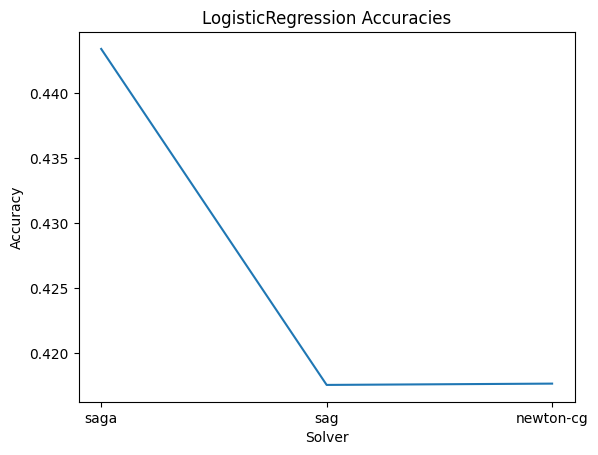

In [13]:
plt.plot(solvers, lr_acc)
plt.title('LogisticRegression Accuracies')
plt.xlabel('Solver')
plt.ylabel('Accuracy');

### Decision Tree
Next is a **Decision Tree** classifier.

In [14]:
criterion = ['gini', 'entropy']
max_depth = [10, 20, None]
min_samples_split = [2, 0.0001]
min_samples_leaf = [1, 5, 10]
max_features = [None, 'sqrt', 'log2']

dt_combos = list(itertools.product(criterion, max_depth, min_samples_split, min_samples_leaf, max_features))

best_dt_model = None
best_dt_param = None
best_dt_acc = 0.0
for combo in dt_combos:
    # set up tree model
    c, md, mss, msl, mf = combo
    tree = DecisionTreeClassifier(
        criterion=c,
        max_depth=md,
        min_samples_split=mss,
        min_samples_leaf=msl,
        max_features=mf,
        class_weight='balanced',
        random_state=1234
    )
    
    # train decision tree
    start_time = time.time()
    tree.fit(X_train, y_train)
    acc = tree.score(X_val, y_val)
    end_time = time.time()
    
    # get results
    print(f'Param {combo} ({end_time - start_time:.1f}s): {acc}')

    # save best
    if acc > best_dt_acc:
        best_dt_model = tree
        best_dt_acc = acc
        best_dt_param = combo

print('=============')
print(f'Best decision tree params are {best_dt_param} with an accuracy of {best_dt_acc}')

Param ('gini', 10, 2, 1, None) (5.3s): 0.48484456702867323
Param ('gini', 10, 2, 1, 'sqrt') (1.4s): 0.3871889904039533
Param ('gini', 10, 2, 1, 'log2') (1.3s): 0.34387749238637016
Param ('gini', 10, 2, 5, None) (4.8s): 0.4834080330977418
Param ('gini', 10, 2, 5, 'sqrt') (1.7s): 0.3590903867149342
Param ('gini', 10, 2, 5, 'log2') (1.4s): 0.28319829914382577
Param ('gini', 10, 2, 10, None) (5.1s): 0.48306326495431823
Param ('gini', 10, 2, 10, 'sqrt') (1.5s): 0.28426133425271505
Param ('gini', 10, 2, 10, 'log2') (1.3s): 0.20707636614376831
Param ('gini', 10, 0.0001, 1, None) (5.1s): 0.48307763029362755
Param ('gini', 10, 0.0001, 1, 'sqrt') (1.7s): 0.35469459288628397
Param ('gini', 10, 0.0001, 1, 'log2') (1.4s): 0.13503418950755616
Param ('gini', 10, 0.0001, 5, None) (5.2s): 0.48248865138194563
Param ('gini', 10, 0.0001, 5, 'sqrt') (1.5s): 0.3645348503131644
Param ('gini', 10, 0.0001, 5, 'log2') (1.3s): 0.2217433775785784
Param ('gini', 10, 0.0001, 10, None) (5.5s): 0.4826035740964202
Par

### Neural Network

In [15]:
nn_sizes = {
    'A1': (20),
    'A2': (50),
    'A3': (100),
    'A4': (200),
    'A5': (50,50),
    'A6': (100,50),
    'A7': (100,100),
    'A8': (200,100),
    'A9': (100,100,100),
    'A10': (50,100,50),
    'A11': (100,100,50),
    'A12': (100,100,100),
    'A13': (100,150,100),
    'A14': (50, 100, 100, 50)
}

best_nn_model = None
best_nn_size = None
best_nn_acc = 0.0

nn_acc = []
for case, size in nn_sizes.items():
    # set up MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=size,
        alpha=0.01,
        random_state=1234,
        early_stopping=True,
    )

    # train MLP
    start_time = time.time()
    mlp.fit(X_train, y_train)
    acc = mlp.score(X_val, y_val)
    end_time = time.time()

    # get results
    print(f'{case} {size} ({end_time - start_time:.1f}s): {acc}')
    nn_acc.append(acc)

    # save best
    if acc > best_nn_acc:
        best_nn_model = mlp
        best_nn_acc = acc
        best_nn_size = size

print('=============')
print(f'Best neural network design is {best_nn_size} with an accuracy of {best_nn_acc}')

A1 20 (11.5s): 0.8471958857668218
A2 50 (40.0s): 0.8473970005171522
A3 100 (31.0s): 0.8479141527322875
A4 200 (67.7s): 0.8474113658564615
A5 (50, 50) (101.2s): 0.8488191691087743
A6 (100, 50) (50.6s): 0.8474257311957708
A7 (100, 100) (48.5s): 0.848531862322588
A8 (200, 100) (220.3s): 0.8499109348962822
A9 (100, 100, 100) (387.1s): 0.850399356432799
A10 (50, 100, 50) (529.6s): 0.8527983680974545
A11 (100, 100, 50) (386.0s): 0.8516778716313279
A12 (100, 100, 100) (363.0s): 0.850399356432799
A13 (100, 150, 100) (259.2s): 0.8496954548066425
A14 (50, 100, 100, 50) (383.2s): 0.8511176233982647
Best neural network design is (50, 100, 50) with an accuracy of 0.8527983680974545


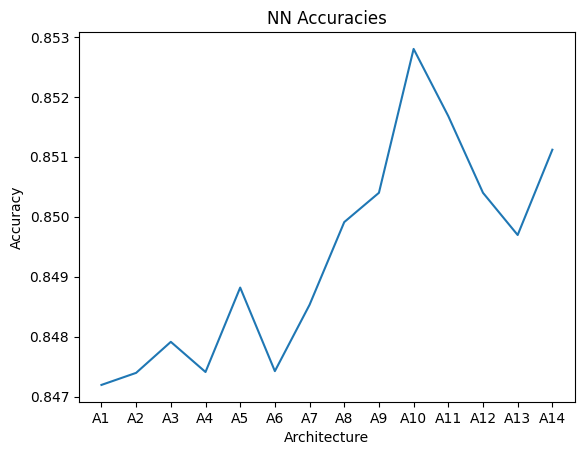

In [16]:
plt.plot(nn_sizes.keys(), nn_acc)
plt.title('NN Accuracies')
plt.xlabel('Architecture')
plt.ylabel('Accuracy');

### KNN

In [17]:
k_values = np.arange(1, 26, 2)

best_knn_model = None
best_k = 0
best_knn_acc = 0.0
knn_acc = []

for k in k_values:
    # set up KNN
    knn = KNeighborsClassifier(
        n_neighbors=k,
        n_jobs=-2
    )

    # train KNN
    start_time = time.time()
    knn.fit(X_train, y_train)
    acc = knn.score(X_val, y_val)
    end_time = time.time()

    # get results
    print(f'K={k} ({end_time - start_time:.1f}s): {acc}')
    knn_acc.append(acc)

    # save best
    if acc > best_knn_acc:
        best_knn_model = knn
        best_knn_acc = acc
        best_k = k

print('=============')
print(f'Best k-value is {best_k} with an accuracy of {best_knn_acc}')

K=1 (118.5s): 0.759955180141355
K=3 (139.6s): 0.8135235304257886
K=5 (137.7s): 0.8317818766879274
K=7 (130.4s): 0.8379877032695512
K=9 (132.6s): 0.8407027523990117
K=11 (119.1s): 0.8425415158306039
K=13 (132.3s): 0.8439924151008447
K=15 (119.3s): 0.8447250474056197
K=17 (129.9s): 0.8457162558179624
K=19 (143.7s): 0.8463052347296444
K=21 (141.5s): 0.8464057921048095
K=23 (135.8s): 0.8466787335516864
K=25 (132.2s): 0.846520714819284
Best k-value is 23 with an accuracy of 0.8466787335516864


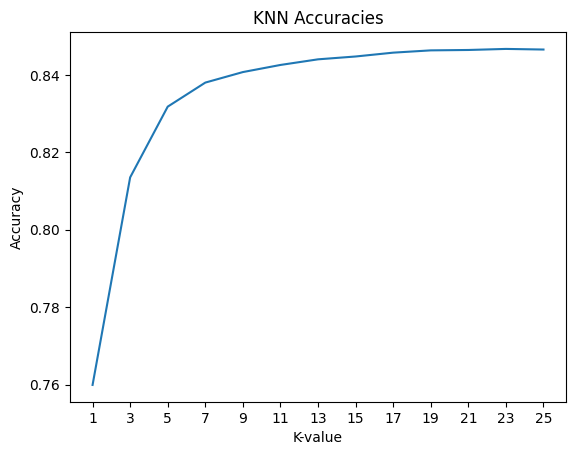

In [18]:
plt.plot([str(k) for k in k_values], knn_acc)
plt.title('KNN Accuracies')
plt.xlabel('K-value')
plt.ylabel('Accuracy');

Elbow is at `k=7`

In [19]:
best_k=7
best_knn_model = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-2)
best_knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-2, n_neighbors=7)

### Comparison
Before we choose the final model, we should evaluate the precision and recall
for each model type.

In [20]:
display_labels=['Severity 1','Severity 2','Severity 3','Severity 4']

#### Logistic Regression

Precision: 0.28887946226350675
Recall:    0.3817875837304787
F1:        0.2481597149239978


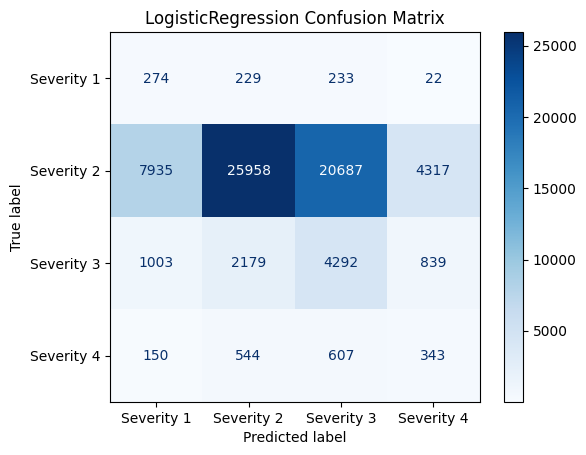

In [21]:
lr_pred = best_lr_model.predict(X_val)

# metrics
lr_precision = precision_score(y_val, lr_pred, average='macro')
lr_recall = recall_score(y_val, lr_pred, average='macro')
lr_f1 = f1_score(y_val, lr_pred, average='macro')
print(f'Precision: {lr_precision}')
print(f'Recall:    {lr_recall}')
print(f'F1:        {lr_f1}')

# confusion matrix
cm = confusion_matrix(y_val, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('LogisticRegression Confusion Matrix');


#### Decision Tree

Precision: 0.39703548712156206
Recall:    0.40911287827908227
F1:        0.40262230392865894


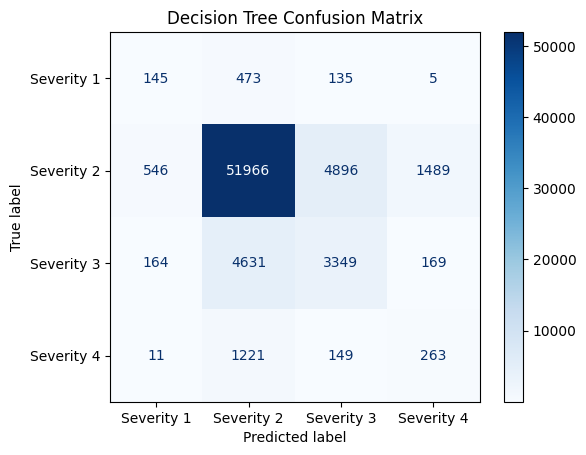

In [22]:
dt_pred = best_dt_model.predict(X_val)

# metrics
dt_precision = precision_score(y_val, dt_pred, average='macro')
dt_recall = recall_score(y_val, dt_pred, average='macro')
dt_f1 = f1_score(y_val, dt_pred, average='macro')
print(f'Precision: {dt_precision}')
print(f'Recall:    {dt_recall}')
print(f'F1:        {dt_f1}')

# confusion matrix
cm = confusion_matrix(y_val, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix');

#### Neural Network

c:\Users\Me\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.4876894834250479
Recall:    0.28573907259198716
F1:        0.29262681210051267


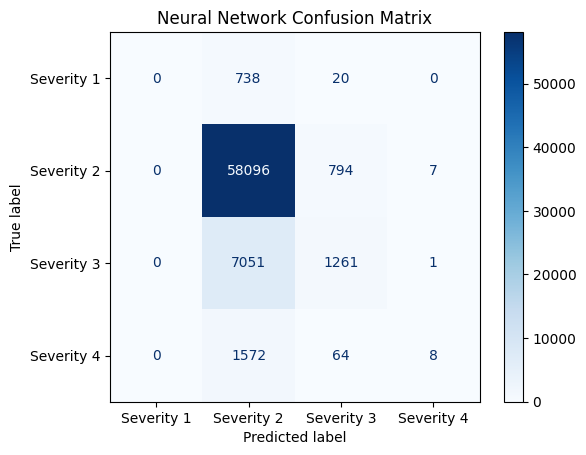

In [23]:
nn_pred = best_nn_model.predict(X_val)

# metrics
nn_precision = precision_score(y_val, nn_pred, average='macro')
nn_recall = recall_score(y_val, nn_pred, average='macro')
nn_f1 = f1_score(y_val, nn_pred, average='macro')
print(f'Precision: {nn_precision}')
print(f'Recall:    {nn_recall}')
print(f'F1:        {nn_f1}')

# confusion matrix
cm = confusion_matrix(y_val, nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix');

#### KNN

Precision: 0.3758269375079675
Recall:    0.2724151429923829
F1:        0.27395820300955637


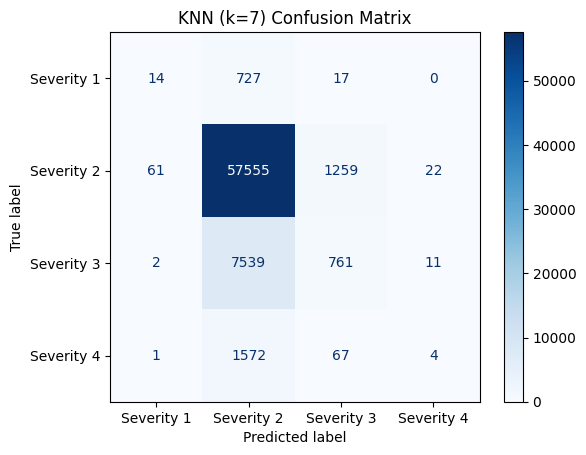

In [24]:
knn_pred = best_knn_model.predict(X_val)

# metrics
knn_precision = precision_score(y_val, knn_pred, average='macro')
knn_recall = recall_score(y_val, knn_pred, average='macro')
knn_f1 = f1_score(y_val, knn_pred, average='macro')
print(f'Precision: {knn_precision}')
print(f'Recall:    {knn_recall}')
print(f'F1:        {knn_f1}')

# confusion matrix
cm = confusion_matrix(y_val, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'KNN (k={best_k}) Confusion Matrix');

### Final Test Performance
In the end, the best performing model was the decision tree. It had the best overall
accuracy and F1 score. We can now run it on the test dataset and evaluate the performance.

Precision: 0.3991928212473761
Recall:    0.40704092299234035
F1:        0.4027515513035673


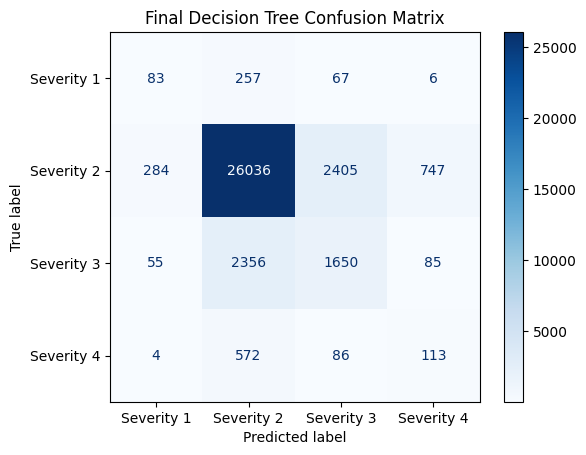

In [25]:
final_acc = best_dt_model.score(X_test, y_test)
test_pred = best_dt_model.predict(X_test)

final_precision = precision_score(y_test, test_pred, average='macro')
final_recall = recall_score(y_test, test_pred, average='macro')
final_f1 = f1_score(y_test, test_pred, average='macro')
print(f'Precision: {final_precision}')
print(f'Recall:    {final_recall}')
print(f'F1:        {final_f1}')

cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Final Decision Tree Confusion Matrix');